# Contrails detection objective-1: Result & discussion

## Data Collection 

In [2]:
import os 
import sys 
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset
from src.model import BaseUnet, SegmentLightning
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

### Images collection and Xarray set

In [3]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_FILE, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.tail()

,Image_ID,Class
11284,3816590513509902394,0
11964,3297656212779292773,0
5390,5369159359735899734,1
860,1431026080843722872,0
15795,1111066390974440788,1


In [33]:
%%time
# Example usage:
smp_df = train_df.head(10)
img_dir = config.DATA_DIR + 'train'
train_ds = utils.load_images_to_dataset(img_dir, smp_df)

(9, 256, 256, 10)
(256, 256, 10)
CPU times: user 218 ms, sys: 366 ms, total: 584 ms
Wall time: 8.85 s


## Data Prepration & Analysis

In [34]:
train_ds

<xarray.Dataset>
Dimensions:   (y: 256, x: 256, band: 10, image_id: 10)
Coordinates:
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * image_id  (image_id) int64 8975896718947475053 ... 1257378571557517683
Dimensions without coordinates: band
Data variables:
    band_8    (y, x, band) float32 231.3 240.7 241.7 243.9 ... 230.5 242.6 233.7
    band_9    (y, x, band) float32 237.5 249.9 247.7 253.0 ... 237.5 252.1 242.0
    band_10   (y, x, band) float32 242.2 259.1 250.9 261.9 ... 244.6 260.2 248.9
    band_11   (y, x, band) float32 252.8 286.6 259.0 292.8 ... 266.6 291.4 259.8
    band_12   (y, x, band) float32 244.8 271.3 243.8 272.5 ... 247.6 271.5 246.5
    band_13   (y, x, band) float32 254.1 289.1 260.8 296.2 ... 268.6 294.8 261.8
    band_14   (y, x, band) float32 250.2 287.1 260.2 295.4 ... 265.6 293.2 261.1
    band_15   (y, x, band) float32 247.2 283.5 258.9 291.8 ... 261.7 289.1 259.5
    band_16   (y, x, band) float32 242.0 271.0 252.9 276.3 ... 252.1 273.9 253.7
    mask      (y, x, band) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [35]:
train_ds.info()
train_ds_X = train_ds.drop('mask')
train_ds_X

xarray.Dataset {
dimensions:
	y = 256 ;
	x = 256 ;
	band = 10 ;
	image_id = 10 ;

variables:
	float32 band_8(y, x, band) ;
	float32 band_9(y, x, band) ;
	float32 band_10(y, x, band) ;
	float32 band_11(y, x, band) ;
	float32 band_12(y, x, band) ;
	float32 band_13(y, x, band) ;
	float32 band_14(y, x, band) ;
	float32 band_15(y, x, band) ;
	float32 band_16(y, x, band) ;
	int32 mask(y, x, band) ;
	int64 y(y) ;
	int64 x(x) ;
	int64 image_id(image_id) ;

// global attributes:
}

<xarray.Dataset>
Dimensions:   (y: 256, x: 256, band: 10, image_id: 10)
Coordinates:
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * image_id  (image_id) int64 8975896718947475053 ... 1257378571557517683
Dimensions without coordinates: band
Data variables:
    band_8    (y, x, band) float32 231.3 240.7 241.7 243.9 ... 230.5 242.6 233.7
    band_9    (y, x, band) float32 237.5 249.9 247.7 253.0 ... 237.5 252.1 242.0
    band_10   (y, x, band) float32 242.2 259.1 250.9 261.9 ... 244.6 260.2 248.9
    band_11   (y, x, band) float32 252.8 286.6 259.0 292.8 ... 266.6 291.4 259.8
    band_12   (y, x, band) float32 244.8 271.3 243.8 272.5 ... 247.6 271.5 246.5
    band_13   (y, x, band) float32 254.1 289.1 260.8 296.2 ... 268.6 294.8 261.8
    band_14   (y, x, band) float32 250.2 287.1 260.2 295.4 ... 265.6 293.2 261.1
    band_15   (y, x, band) float32 247.2 283.5 258.9 291.8 ... 261.7 289.1 259.5
    band_16   (y, x, band) float32 242.0 271.0 252.9 276.3 ... 252.1 273.9 253.7

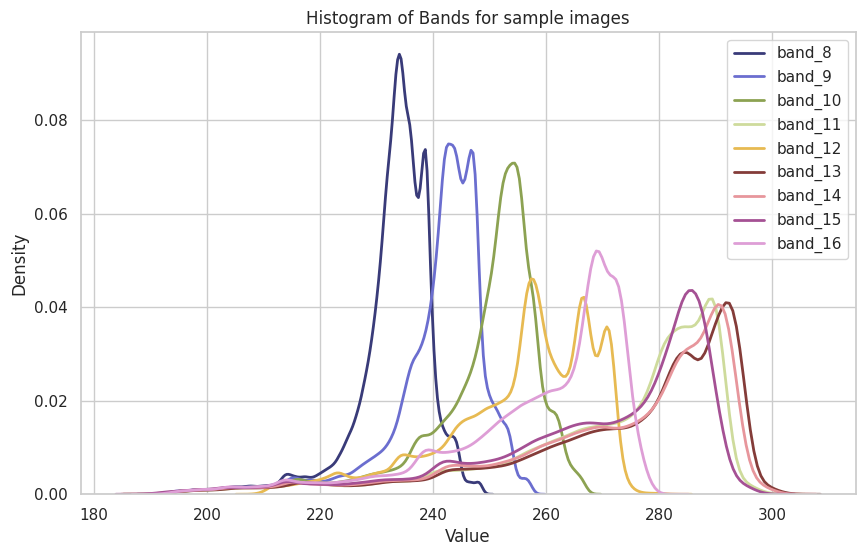

CPU times: user 59.2 s, sys: 58.7 s, total: 1min 57s
Wall time: 26.4 s


In [36]:
%%time
utils.plot_dataset_band_hist(train_ds_X, 'Histogram of Bands for sample images')

### Image pixels dataset at mask value 0 and 1

In [7]:
%%time
## Dataset splits
# Image mask with label 0 and 1
ds_mask_0 = train_ds.where(train_ds['mask'] == 0, drop=True)
ds_mask_1 = train_ds.where(train_ds['mask'] == 1, drop=True)

ds_mask_1

CPU times: user 190 ms, sys: 57.1 ms, total: 247 ms
Wall time: 275 ms


<xarray.Dataset>
Dimensions:   (y: 256, x: 256, band: 4, image_id: 10)
Coordinates:
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * image_id  (image_id) int64 913839717035889567 ... 8013461851091438962
Dimensions without coordinates: band
Data variables:
    band_8    (y, x, band) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_9    (y, x, band) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_10   (y, x, band) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_11   (y, x, band) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_12   (y, x, band) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_13   (y, x, band) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_14   (y, x, band) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_15   (y, x, band) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_16   (y, x, band) float32 nan nan nan nan nan ... nan nan nan nan nan
    mask      (y, x, band) float64 nan nan nan nan nan ... nan nan nan nan nan

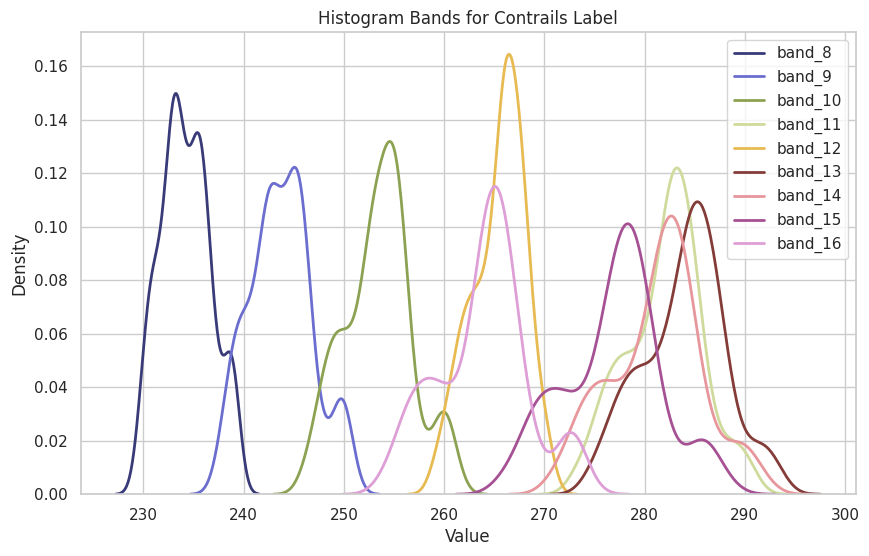

CPU times: user 4.96 s, sys: 6.53 s, total: 11.5 s
Wall time: 810 ms


In [18]:
%%time
utils.plot_dataset_band_hist(ds_mask_1.drop('mask'), 'Histogram Bands pixels with Contrails')

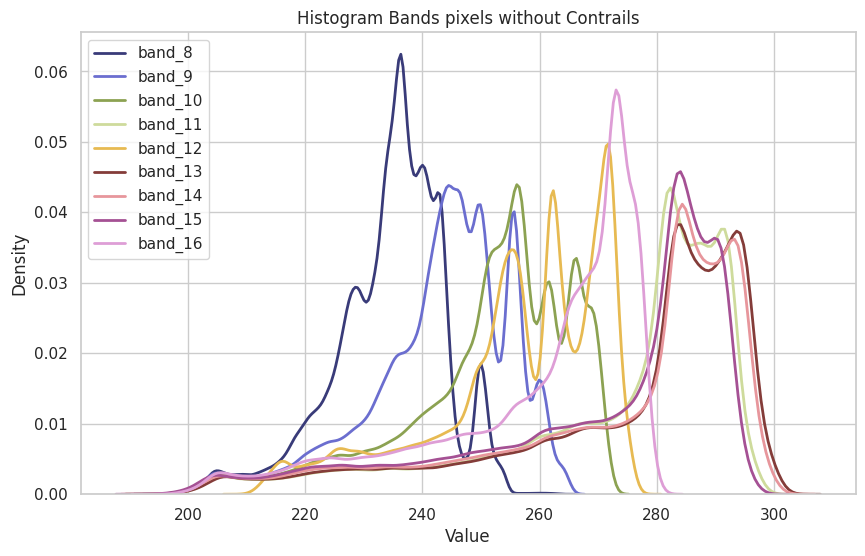

In [19]:
%%time
utils.plot_dataset_band_hist(ds_mask_0.drop('mask'), 'Histogram Bands pixels without Contrails')

## Bands Normalization & Processing

In [134]:
from scipy.ndimage import gaussian_filter
import xarray as xr

def enhance_contrast(image, kernel_size=5, k=0.1):
    """
    Enhances the contrast of an image using the described method.

    Args:
        image (np.ndarray): Input image (either T5i or TD).
        kernel_size (int): Size of the Gaussian kernel (default is 5).
        k (float): Constant added to local standard deviation to prevent division by zero (default is 0.1).

    Returns:
        np.ndarray: Contrast-enhanced image.
    """
    # Apply Gaussian smoothing to the image
    smoothed_image = gaussian_filter(image, sigma=kernel_size)

    # Calculate the local standard deviation
    local_std = np.sqrt(gaussian_filter((image - smoothed_image) ** 2, sigma=kernel_size))

    # Normalize the image
    normalized_image = (image - smoothed_image) / (local_std + k)

    # Clip values to range -2 to +2
    normalized_image = np.clip(normalized_image, -2, 2)

    return normalized_image

def process_geos_data(dataset, kernel_size=3, k=0.1):
    """
    Process GEOS-16 satellite data to enhance contrast of contrails.

    Args:
        dataset (xr.Dataset): The input xarray dataset containing bands.
        kernel_size (int): Size of the Gaussian kernel for smoothing (default is 5).
        k (float): Constant added to local standard deviation (default is 0.1).

    Returns:
        xr.Dataset: The processed xarray dataset with enhanced contrast.
    """
    # Extract Channel 4 (band-13) and Channel 5 (band-14)
    channel_4 = dataset['band_8'].values
    channel_5 = dataset['band_13'].values

    # Calculate Brightness Temperature Difference (TD)
    TD = channel_5 - channel_4

    # Invert Channel 5 temperature data
    T5i = -channel_5

    # Enhance contrast for both Channel 5 and TD
    enhanced_T5 = enhance_contrast(T5i, kernel_size, k)
    enhanced_TD = enhance_contrast(TD, kernel_size, k)

    # Create new xarray Dataset with enhanced images
    new_dataset = xr.Dataset({
        'enhanced_band_8': (('y', 'x', 'band'), enhanced_T5),
        'enhanced_band_13': (('y', 'x', 'band'), enhanced_TD)
    }, coords=dataset.coords)

    return new_dataset


## RGB Xarray 

def normalize_range(data, bounds):
    """Normalizes xarray.DataArray to 0-1 range."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def get_ash_rgb(dataset):
    """Gets Ash RGB from a GOES-16 xarray dataset."""

    # Extract bands as xarray.DataArray objects
    band15 = dataset['band_15']
    band14 = dataset['band_14']
    band11 = dataset['band_11']
    band13 = dataset['band_13']

    # Calculate Ash RGB components
    r = normalize_range(band15 - band13, (-0.015, 0.008))
    g = normalize_range(band14 - band11, (-0.015, 0.02))
    b = normalize_range(band11, (0.9, 1.2))

    # Create xarray.DataArray for Ash RGB
    ash_rgb = xr.DataArray(
        np.stack([r, g, b], axis=-1),  # Stack as RGB channels
        dims=('y', 'x', 'rgb'),        # Set dimensions
        coords=dataset.coords,         # Use original coordinates
        name='ash_rgb'                 # Give the variable a name
    )

    return ash_rgb

# RGB & Enhancement 
def get_ash_rgb(dataset):
    """Gets Ash RGB from a GOES-16 xarray dataset."""

    _T11_BOUNDS = (0.9, 1.2)
    _CLOUD_TOP_TDIFF_BOUNDS = (-0.015, 0.02)
    _TDIFF_BOUNDS = (-0.015, 0.008)

    # Extract bands as xarray.DataArray objects
    band15 = dataset['band_15']
    band14 = dataset['band_14']
    band11 = dataset['band_11']
    band13 = dataset['band_13']

    # Calculate Ash RGB components
    r = normalize_range(band15 - band13, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band11, _T11_BOUNDS)

    # Create xarray.Dataset for Ash RGB
    ash_rgb_dataset = xr.Dataset({
        'R': (('y', 'x'), r.data),
        'G': (('y', 'x'), g.data),
        'B': (('y', 'x'), b.data)
    }, coords=dataset.coords)  # Inherit coordinates

    return ash_rgb_dataset

In [94]:
enhanced_ds

<xarray.Dataset>
Dimensions:           (y: 256, x: 256, band: 10, image_id: 10)
Coordinates:
  * y                 (y) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
  * x                 (x) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
  * image_id          (image_id) int64 8975896718947475053 ... 12573785715575...
Dimensions without coordinates: band
Data variables:
    enhanced_band_8   (y, x, band) float32 1.29 -0.9248 0.8937 ... -1.302 0.5564
    enhanced_band_13  (y, x, band) float32 -1.139 0.8375 ... 1.194 -0.5993

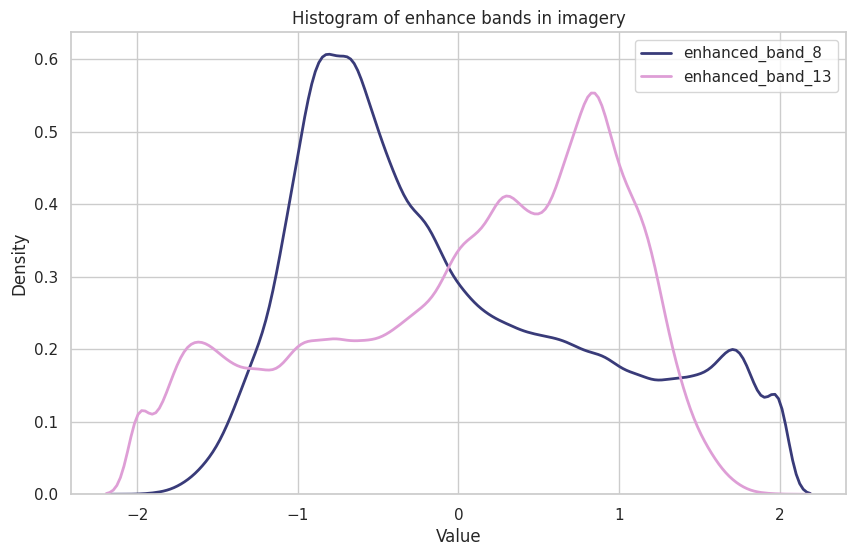

CPU times: user 14.9 s, sys: 14 s, total: 28.9 s
Wall time: 6.83 s


In [56]:
%%time
utils.plot_dataset_band_hist(enhanced_ds, 'Histogram of enhance bands in imagery')

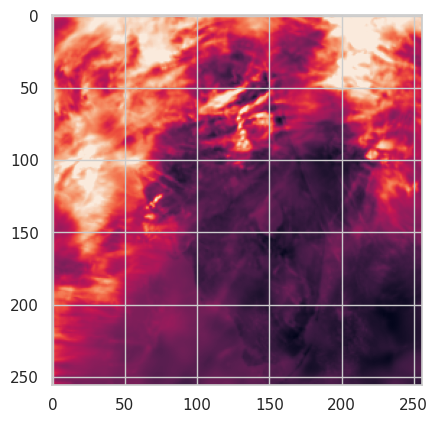

In [75]:
plt.imshow(enhanced_ds['enhanced_band_8'][:,:,4])

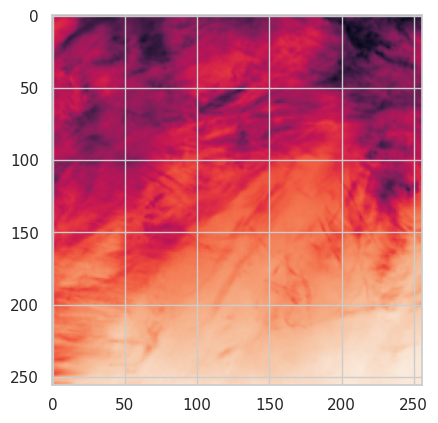

In [76]:
plt.imshow(train_ds['band_8'][...,4])

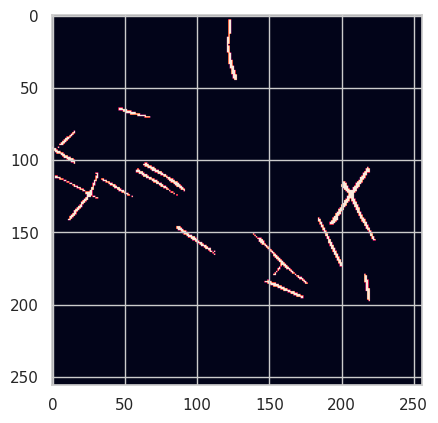

In [74]:
plt.imshow(train_ds['mask'][...,4])